# COMP69901 CW 3 - Irrigation Scheduling

### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

### Modelling

#### 1. Single Start Irrigation Event Simulation

Let us assume that irrigation only occurs at start in a soil system without external disturbances, where volumetric soil moisture follows exponential decay

\begin{aligned}
\dfrac{d\theta}{dt} &= - \lambda \theta(t), \\
\theta(t) &= \theta_0 e^{-\lambda t}.
\end{aligned}

Further, assume that we have stationary sensor noise when recording volumetric soil moisture

$$
\hat{\theta}(t) = \theta(t) e^\epsilon,\quad \epsilon \sim N(0,\sigma_\theta^2).
$$
We chose this model as it satisfies the constraints of our sensor being noisy, but can only return positive values.

We record observations at regular intervals, and would like to determine $\theta_0$ and $\lambda$.

In [3]:
class SingleStartIrrigationSim:
    def __init__(self, theta0, lam, sigma_theta):
        self.soil_moist = theta0
        self.theta0 = theta0
        self.lam = lam
        self.sigma_theta = sigma_theta
        self.time = 0.0
        self.data = {
            'latent' : {
                't' : [0.0],
                'y' : [theta0]
            },
            'observed' : {
                't' : [],
                'y' : []
            }
        }
    
    def update(self, dt):
        self.time += dt
        self.soil_moist = self.theta0 * np.exp(-self.lam * self.time)
        self.data['latent']['t'].append(self.time)
        self.data['latent']['y'].append(self.soil_moist)

    def observation(self):
        self.data['observed']['t'].append(self.time)
        self.data['observed']['y'].append(self.soil_moist * np.exp(np.random.normal(0, self.sigma_theta)))

In [82]:
theta0 = 50
lam = 0.05
dt = 0.1
obs_interval = 15
t = 60 * 24
sigma_theta = 0.3
min_threshold = sigma_theta

# run simulation
sim = SingleStartIrrigationSim(theta0, lam, sigma_theta)

obs_timer = 0
while (sim.time < t) and (sim.soil_moist > min_threshold or sim.data['observed']['y'][-1] > min_threshold):
    sim.update(dt)
    obs_timer += dt
    if obs_timer >= obs_interval:
        sim.observation()
        obs_timer = 0
sim.data['observed']['t'] = sim.data['observed']['t'][:-1]
sim.data['observed']['y'] = sim.data['observed']['y'][:-1]

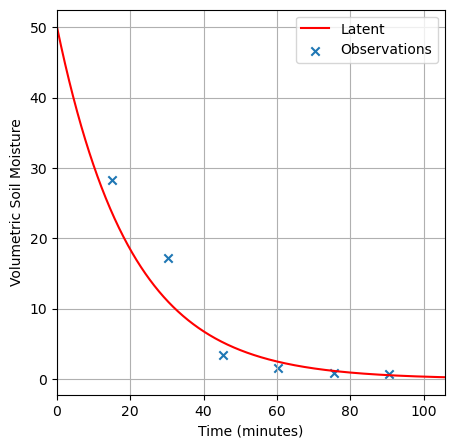

In [83]:
# plot results
fig, ax = plt.subplots(1,1, figsize=(5, 5))

ax.plot(sim.data['latent']['t'], sim.data['latent']['y'], label='Latent', color='red')  
ax.scatter(sim.data['observed']['t'], sim.data['observed']['y'], marker='x', label='Observations')

ax.grid()

ax.set_xlim(0, sim.time)

ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Volumetric Soil Moisture')
ax.legend()
plt.show()

In [84]:
ts = np.array(sim.data['observed']['t'])
obs = np.array(sim.data['observed']['y'])
latents = []
for t in ts:
    idx = np.where(sim.data['latent']['t'] == t)[0][0]
    latents.append(sim.data['latent']['y'][idx])
latents = np.array(latents)

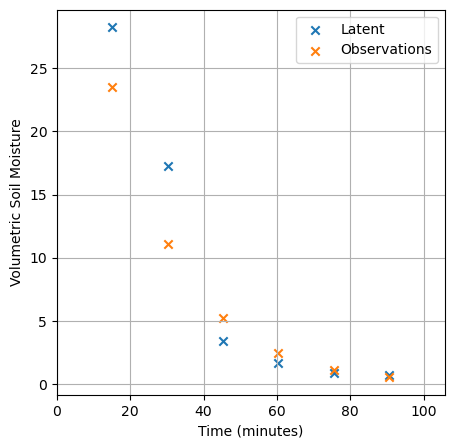

In [85]:
fig, ax = plt.subplots(1,1, figsize=(5, 5))

ax.scatter(ts, obs, marker='x', label='Latent')  
ax.scatter(ts, latents, marker='x', label='Observations')

ax.grid()

ax.set_xlim(0, sim.time)

ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Volumetric Soil Moisture')
ax.legend()
plt.show()

Now, assume we would like to estimate $\theta_0$ and $\lambda$

\begin{aligned}
\log \hat{\theta} (t) &= \log \theta(t) e^\epsilon \\
                      &= \log \theta(t) + \epsilon \\
                      &= - \lambda t + \log \theta_0 + \epsilon \equiv (a t + b) + \epsilon
\end{aligned}

Thus, we can learn $\theta_0$ and $\lambda$ from bayesian linear regression on $\log \hat{\theta}(t)$.

If we define our prior over variables $\theta_0$ and $\lambda$ to be normal and exponentially distributed we get our prior likelihood:

Normal: 
$$\log \theta_0 \sim N(\mu_{\log\theta_0}, \sigma^2_{\log\theta_0})$$
Exp: 
$$\lambda \sim \text{Exp}(\beta)$$
Likelihood
$$\log \hat{\theta}(t_i) \sim N(\log \theta_0 - \lambda t_i,\; \sigma_\theta^2)$$

$$\text{P}(\{\hat\theta({t_i})\} | \text{log}\theta_{0}, \lambda)=\prod_i\frac{1}{\sqrt{2\pi\sigma{\theta}}}\frac{(\log\hat\theta(t_i)-[\log\theta_0 - \lambda t_i])}{2 \sigma _\theta ^ 2}$$

The posterior is not solvable analytically and must be approximated, here we use metropolis hastings.
1. We propose new values using gaussian centered at previous estimation
2. We compute $\alpha$ 
3. Accept or Reject and repeat for X iterations 
\begin{aligned}
\alpha = \frac{p(\text{data} \mid \log \theta_0{\prime}, \lambda{\prime}) p(\log \theta_0{\prime}, \lambda{\prime})}{p(\text{data} \mid \log \theta_0, \lambda) p(\log \theta_0, \lambda)}
\times \frac{q((\log \theta_0, \lambda)\mid(\log \theta_0{\prime}, \lambda{\prime}))}{q((\log \theta_0{\prime}, \lambda{\prime})\mid(\log \theta_0, \lambda))}
\end{aligned}

In [147]:
import numpy as np

# Example data (t and observed moisture)
# Replace with real or simulated data
t_data = ts  # time in minutes
obs_data = obs  # observed moisture
sigma_theta = 0.3  # known observation noise std dev

# Compute log of observations (since model is log-linear)
log_obs_data = np.log(obs_data)

# Priors:
# log_theta0 ~ Normal(mu_logtheta0, sigma_logtheta0^2)
mu_logtheta0 = 10
sigma_logtheta0 = 5.0

lambda_rate = 1.0


def log_prior(log_theta0, lam):
    lp_logtheta0 = -0.5*((log_theta0 - mu_logtheta0)**2)/(sigma_logtheta0**2) - np.log(np.sqrt(2*np.pi)*sigma_logtheta0)
    if lam <= 0:
        return -np.inf
    lp_lambda = np.log(lambda_rate) - lambda_rate * lam
    return lp_logtheta0 + lp_lambda

def log_likelihood(log_theta0, lam):
    pred = log_theta0 - lam * t_data
    residuals = log_obs_data - pred
    ll = -0.5 * np.sum((residuals**2)/(sigma_theta**2)) - len(t_data)*np.log(np.sqrt(2*np.pi)*sigma_theta)
    return ll

def log_posterior(log_theta0, lam):
    lp = log_prior(log_theta0, lam)
    if np.isinf(lp):
        return -np.inf
    return lp + log_likelihood(log_theta0, lam)

n_samples = 10000
samples = np.zeros((n_samples, 2)) 
accept_count = 0

current_logtheta0 = 1  
current_lam = 1
current_logpost = log_posterior(current_logtheta0, current_lam)

# Proposal standard deviations
proposal_std_logtheta0 = 0.1
proposal_std_lambda = 0.01
likelihood = [] 
for i in range(n_samples):
    prop_logtheta0 = current_logtheta0 + np.random.normal(0, proposal_std_logtheta0)
    prop_lam = current_lam + np.random.normal(0, proposal_std_lambda)

    likelihood.append(log_likelihood(current_logtheta0, lam)) 
    prop_logpost = log_posterior(prop_logtheta0, prop_lam)
    alpha = np.exp(prop_logpost - current_logpost)
    if np.random.rand() < alpha:
        current_logtheta0 = prop_logtheta0
        current_lam = prop_lam
        current_logpost = prop_logpost
        accept_count += 1

    samples[i, 0] = current_logtheta0
    samples[i, 1] = current_lam

accept_rate = accept_count / n_samples
print("Acceptance Rate:", accept_rate)

burn_in = 1000
post_samples = samples[burn_in:]

mean_logtheta0 = np.mean(post_samples[:,0])
mean_lam = np.mean(post_samples[:,1])
std_logtheta0 = np.std(post_samples[:,0])
std_lam = np.std(post_samples[:,1])

print("Posterior mean of log_theta0:", mean_logtheta0, "±", std_logtheta0)
print("Posterior mean of lambda:", mean_lam, "±", std_lam)

mean_theta0 = np.exp(mean_logtheta0)
std_theta0 = np.exp(std_logtheta0)
print("Posterior mean of theta0:", mean_theta0, "±", std_theta0)

Acceptance Rate: 0.2237
Posterior mean of log_theta0: 3.732245006328515 ± 1.0204447838706716
Posterior mean of lambda: 0.09106048224370342 ± 0.14518507108432951
Posterior mean of theta0: 41.772783136733764 ± 2.774428510620507


/var/folders/8w/vd4m4l915_3c6x0yswt12tfr0000gp/T/ipykernel_30216/2170590556.py:59: RuntimeWarning: overflow encountered in exp
  alpha = np.exp(prop_logpost - current_logpost)


#### 2. Regular Irrigation Event Simulation

I have not actually figured any of this out other than guessing, but I will use this equation

\begin{aligned}
\theta(t) &= \theta_{0} \sum_{i} e^{-\lambda (t-t_i)} \delta(t - t_i).
\end{aligned}


Further, assume that we have stationary sensor noise when recording volumetric soil moisture

$$
\hat{\theta}(t) = \theta(t) e^\epsilon,\quad \epsilon \sim N(0,\sigma_\theta^2).
$$

In [9]:
class RegularIrrigationSim:
    def __init__(self, theta0, starts, lam, sigma_theta):
        self.soil_moist = theta0 * np.dot(np.ones_like(starts), 0 >= starts)
        self.theta0 = theta0
        self.lam = lam
        self.sigma_theta = sigma_theta
        self.time = 0.0
        self.starts = starts
        self.data = {
            'latent' : {
                't' : [0.0],
                'y' : [self.soil_moist]
            },
            'observed' : {
                't' : [],
                'y' : []
            }
        }
    
    def update(self, dt):
        self.soil_moist = self.theta0 * np.dot(np.exp(-self.lam * (self.time - self.starts)), self.time >= self.starts)
        self.time += dt
        self.data['latent']['t'].append(self.time)
        self.data['latent']['y'].append(self.soil_moist)

    def observation(self):
        self.data['observed']['t'].append(self.time)
        self.data['observed']['y'].append(self.soil_moist * np.exp(np.random.normal(0, self.sigma_theta)))

In [10]:
theta0 = 50
starts = np.array([0, 100, 200])
lam = 0.05
dt = 0.1
obs_interval = 15
t = 60 * 24
sigma_theta = 0.3
min_threshold = sigma_theta

# run simulation
sim = RegularIrrigationSim(theta0, starts, lam, sigma_theta)

obs_timer = 0
while (sim.time < t) and (sim.soil_moist > min_threshold):
    sim.update(dt)
    obs_timer += dt
    if obs_timer >= obs_interval:
        sim.observation()
        obs_timer = 0
sim.data['observed']['t'] = sim.data['observed']['t'][:-1]
sim.data['observed']['y'] = sim.data['observed']['y'][:-1]

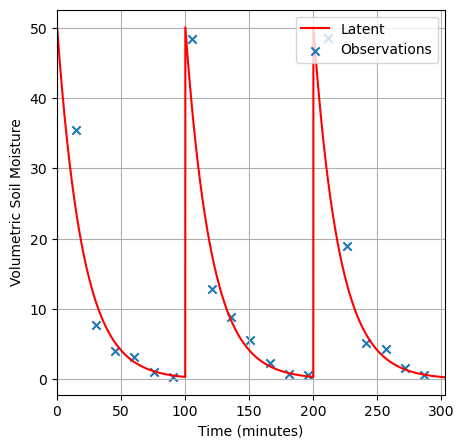

In [11]:
# plot results
fig, ax = plt.subplots(1,1, figsize=(5, 5))

ax.plot(sim.data['latent']['t'], sim.data['latent']['y'], label='Latent', color='red')  
ax.scatter(sim.data['observed']['t'], sim.data['observed']['y'], marker='x', label='Observations')

ax.grid()

ax.set_xlim(0, sim.time)

ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Volumetric Soil Moisture')
ax.legend()
plt.show()

Now, assume we would like to estimate $\theta_0$ and $\lambda$

\begin{aligned}
\log \hat{\theta} (t) &= \log \theta(t) e^\epsilon \\
                      &= \log \theta(t) + \epsilon \\
                      &= \log \sum_{t \geq t_i} e^{- \lambda (t-t_i)} + \log \theta_0 + \epsilon \\
                      &\approx - \lambda (t-t_i^*) + \log \theta_0 + \epsilon
\end{aligned}
where $t_i^* = \max_{t_i \in \{t_i \mid t \geq t_i \}} t_i$

Thus, we can learn $\theta_0$ and $\lambda$ from bayesian linear regression on $\log \hat{\theta}(t)$, if we can seperate data points by which irrigation cycle they are in, which as we are the irrigators, we know exactly when this is :)

In [12]:
### TODO Bayesian Linear Regression with change correction

#### 3. Regular Variable Irrigation Event Simulation



\begin{aligned}
\theta(t) &= \sum_{i} \theta_i e^{-\lambda (t-t_i)} \delta(t - t_i).
\end{aligned}


Further, assume that we have stationary sensor noise when recording volumetric soil moisture

$$
\hat{\theta}(t) = \theta(t) e^\epsilon,\quad \epsilon \sim N(0,\sigma_\theta^2).
$$

In [13]:
class RegularVariableIrrigationSim:
    def __init__(self, theta0, starts, lam, sigma_theta):
        self.soil_moist = np.dot(theta0, 0 >= starts)
        self.theta0 = theta0
        self.lam = lam
        self.sigma_theta = sigma_theta
        self.time = 0.0
        self.starts = starts
        self.data = {
            'latent' : {
                't' : [0.0],
                'y' : [self.soil_moist]
            },
            'observed' : {
                't' : [],
                'y' : []
            }
        }
    
    def update(self, dt):
        self.soil_moist = np.dot(self.theta0 * np.exp(-self.lam * (self.time - self.starts)), self.time >= self.starts)
        self.time += dt
        self.data['latent']['t'].append(self.time)
        self.data['latent']['y'].append(self.soil_moist)

    def observation(self):
        self.data['observed']['t'].append(self.time)
        self.data['observed']['y'].append(self.soil_moist * np.exp(np.random.normal(0, self.sigma_theta)))

In [14]:
theta0 = np.array([50, 40, 60])
starts = np.array([0, 100, 175])
lam = 0.05
dt = 0.1
obs_interval = 15
t = 60 * 24
sigma_theta = 0.3
min_threshold = sigma_theta

# run simulation
sim = RegularVariableIrrigationSim(theta0, starts, lam, sigma_theta)
obs_timer = 0
while (sim.time < t) and (sim.soil_moist > min_threshold):
    sim.update(dt)
    obs_timer += dt
    if obs_timer >= obs_interval:
        sim.observation()
        obs_timer = 0
sim.data['observed']['t'] = sim.data['observed']['t'][:-1]
sim.data['observed']['y'] = sim.data['observed']['y'][:-1]

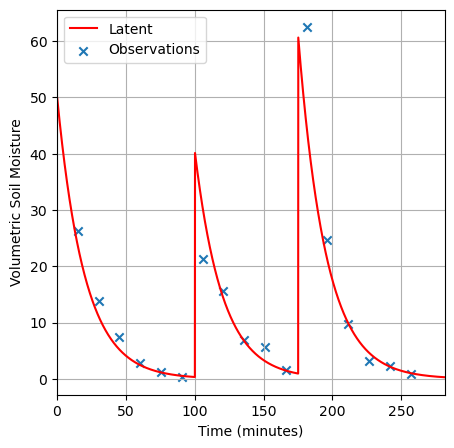

In [15]:
# plot results
fig, ax = plt.subplots(1,1, figsize=(5, 5))

ax.plot(sim.data['latent']['t'], sim.data['latent']['y'], label='Latent', color='red')  
ax.scatter(sim.data['observed']['t'], sim.data['observed']['y'], marker='x', label='Observations')

ax.grid()

ax.set_xlim(0, sim.time)

ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Volumetric Soil Moisture')
ax.legend()
plt.show()

Now, assume we would like to estimate $\theta_i$ and $\lambda$

\begin{aligned}
\log \hat{\theta} (t) &= \log \theta(t) e^\epsilon \\
                      &= \log \theta(t) + \epsilon \\
                      &= \log \sum_{t \geq t_i} \theta_i e^{- \lambda (t-t_i)} + \epsilon \\
                      &\approx - \lambda (t-t_i^*) + \log \theta_i^* + \epsilon
\end{aligned}
where $t_i^* = \max_{t_i \in \{t_i \mid t \geq t_i \}} t_i$

Thus, we can learn $\theta_i$ and $\lambda$ from bayesian linear regression on $\log \hat{\theta}(t)$, if we can seperate data points by which irrigation cycle they are in, which as we are the irrigators, we know exactly when this is :)

In [16]:
### TODO Bayesian Linear regression

#### 4. Regular Variable Irrigation with Bias Event Simulation (You can simulate this, but parameter estimation becomes problematic)


\begin{aligned}
\theta(t) &= \sum_{i} (\theta_i e^{-\lambda (t-t_i)} + \beta_i ) \delta(t - t_i) \delta(t_{i+1} - t).
\end{aligned}


Further, assume that we have stationary sensor noise when recording volumetric soil moisture

$$
\hat{\theta}(t) =  \sum_{i} (\theta_i e^{-\lambda (t-t_i)} e^\epsilon  + \beta_i) \delta(t - t_i) \delta(t_{i+1} - t) ,\quad \epsilon \sim N(0,\sigma_\theta^2).
$$


\begin{aligned}
\log \left(\hat{\theta} (t) - \sum_i \beta_i \delta(t - t_i)\right) &= \log \left(\sum_{i} (\theta_i e^{-\lambda (t-t_i)} + \beta_i) \delta(t - t_i) \right) \\
                      &= \log \left(\theta_i e^{- \lambda (t-t_i)+\epsilon}  +\beta_i \right)\\
                      &= \log \left(\frac{\theta_i}{\beta_i} e^{- \lambda (t-t_i) + \epsilon} + 1 \right) + \log{\beta_i} \\
\end{aligned}

for $t>>\lambda, \theta(t) \approx \beta_i$

Remove $\beta_i$ like this, then do as before, i.e., when delta t is less than certain amount, take mean of values / just take final value to be $\beta_i$

In [17]:
class RegularVariableIrrigationSim:
    def __init__(self, theta0, starts, lam, betas, sigma_theta):
        self.soil_moist = np.dot(theta0 + betas, 0 >= starts)
        self.theta0 = theta0
        self.lam = lam
        self.betas = betas
        self.sigma_theta = sigma_theta
        self.time = 0.0
        self.starts = starts
        self.data = {
            'latent' : {
                't' : [0.0],
                'y' : [self.soil_moist]
            },
            'observed' : {
                't' : [],
                'y' : []
            }
        }
    
    def update(self, dt):
        self.soil_moist = np.dot(self.theta0 * np.exp(-self.lam * (self.time - self.starts)) + self.betas, self.time >= self.starts)
        self.time += dt
        self.data['latent']['t'].append(self.time)
        self.data['latent']['y'].append(self.soil_moist)

    def observation(self):
        self.data['observed']['t'].append(self.time)
        self.data['observed']['y'].append(self.soil_moist * np.exp(np.random.normal(0, self.sigma_theta)))

In [18]:
theta0 = np.array([50, 40, 60])
starts = np.array([0, 100, 175])
lam = 0.05
betas = np.array([0, 10, 20])
dt = 0.1
obs_interval = 15
t = 60 * 24
sigma_theta = 0.3
min_threshold = sigma_theta

# run simulation
sim = RegularVariableIrrigationSim(theta0, starts, lam, betas, sigma_theta)
obs_timer = 0
while (sim.time < t) and (sim.soil_moist > min_threshold):
    sim.update(dt)
    obs_timer += dt
    if obs_timer >= obs_interval:
        sim.observation()
        obs_timer = 0
sim.data['observed']['t'] = sim.data['observed']['t'][:-1]
sim.data['observed']['y'] = sim.data['observed']['y'][:-1]

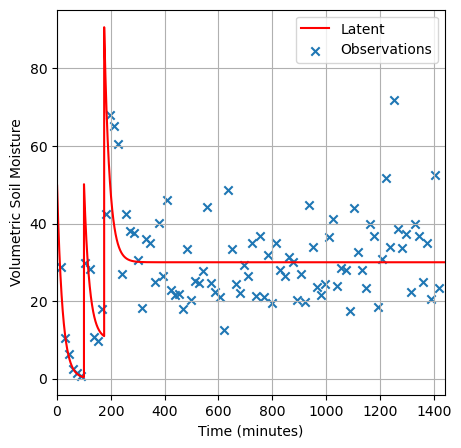

In [19]:
# plot results
fig, ax = plt.subplots(1,1, figsize=(5, 5))

ax.plot(sim.data['latent']['t'], sim.data['latent']['y'], label='Latent', color='red')  
ax.scatter(sim.data['observed']['t'], sim.data['observed']['y'], marker='x', label='Observations')

ax.grid()

ax.set_xlim(0, sim.time)

ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Volumetric Soil Moisture')
ax.legend()
plt.show()

We are stuck with this model :( Because of how we define our error, it behaves very strangely

Follow up ideas:

- Treat as periodic gaussian process (use irrigation interval) - use exponential kernel
- Treat as periodic orhnstein-uhlembeck process - (multiply uhlembeck ornhstein kernel by periodic kernel)

- Use schroeder's backward integration method to determine decay rate (assumes additive noise) - Xiang propose a bayesian approach to this in a paper, yet to look to deeply at it - but we could do it with bayesian quadrature?

Now lets try this on the real-world data!